In [1]:
import numpy as np
from matplotlib import pyplot as plt

from metpy.plots import Hodograph

import pyart

from pathlib import Path
root = Path.cwd()


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



First make sure we are merging separete sweeps into one volume. We do this with RadxConvert from lrose. Installation instructions are [here](https://github.com/NCAR/lrose-core/blob/master/docs/build/LROSE_cmake_build.auto.md). We will also need netcdf (ncdump specifically) to run the given script. Run the following in terminal, it requires input:

```bash
./merge_cfrad.sh ./data_in/cfrad.20240524_000012_RaXPol_v32_s1.nc -o ./
```

Now we look at our generated file:

In [2]:
filePath = root/"20240524"/"cfrad.20240524_000012.000_to_20240524_000034.000_RaXPol_SUR.nc"
radar = pyart.io.read(filePath)

Let's plot a basic PPI to see what the data looks like:

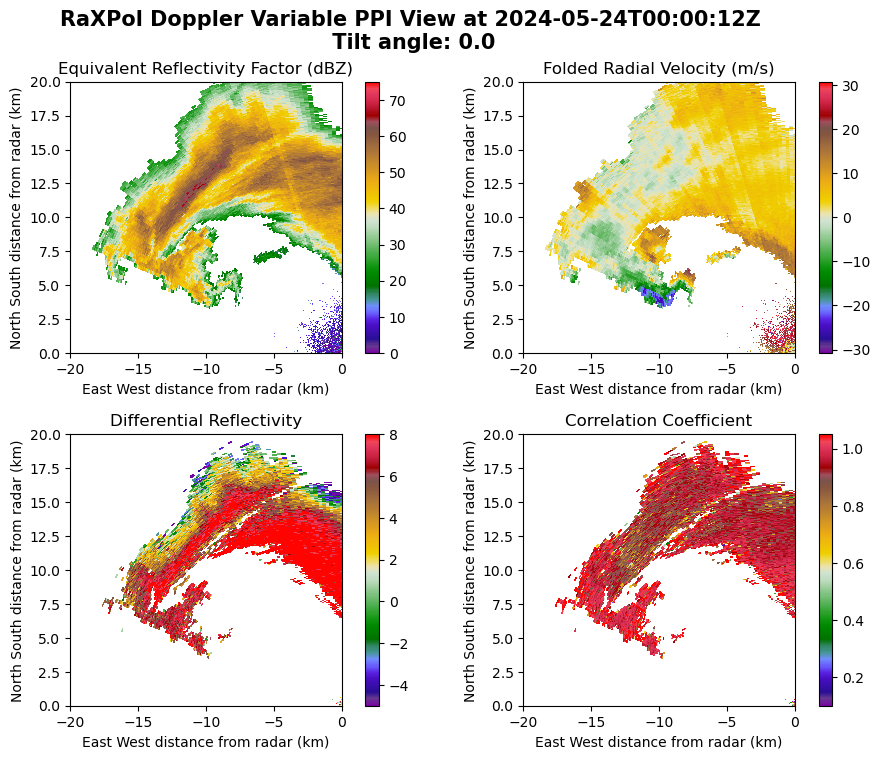

In [3]:
display = pyart.graph.RadarDisplay(radar)
timeStr = pyart.graph.common.generate_radar_time_sweep(radar, sweep=0).isoformat() + "Z"
tilt = radar.fixed_angle["data"][0]
fields_to_plot = {
    'DBZ': {
        'ranges': (0, 75),
        'cmap': 'pyart_Carbone42',
        'title': 'Equivalent Reflectivity Factor (dBZ)'
    },
    'VEL': {
        'ranges': (-radar.get_nyquist_vel(0), radar.get_nyquist_vel(0)),
        'cmap': 'pyart_Carbone42',
        'title': 'Folded Radial Velocity (m/s)'
    },
    'ZDR': {
        'ranges': (-5, 8),
        'cmap': 'pyart_Carbone42',
        'title': 'Differential Reflectivity'
    },
    'RHOHV': {
        'ranges': (0.1, 1.05),
        'cmap': 'pyart_Carbone42',
        'title': 'Correlation Coefficient'
    } 
}

xlim = [-20, 0]
ylim = [0, 20]

plt.figure(figsize=[12, 8])

for plot_num, field in enumerate(fields_to_plot.keys()):
    vmin, vmax = fields_to_plot[field]['ranges']
    cmap = fields_to_plot[field]['cmap']

    plt.subplot(2, 2, plot_num+1)
    plt.axis('scaled')
    display.plot_ppi(field, vmin=vmin, vmax=vmax, cmap=cmap, title_flag=False, sweep=0)
    display.set_limits(xlim=xlim, ylim=ylim)
    display.cbs[plot_num].set_label('')
    plt.title(fields_to_plot[field]['title'])

plt.subplots_adjust(top=0.89, wspace=-0.05, hspace=0.3)
plt.suptitle('RaXPol Doppler Variable PPI View at ' + timeStr + "\n Tilt angle: " + str(round(tilt, 2)) , weight='bold', fontsize=15)
plt.show()

Okay, now let's compute the VAD. Adapted example code from [here](https://arm-doe.github.io/pyart/examples/retrieve/plot_vad.html).

In [4]:
zlevels = np.arange(100, 5000, 100)
u_allsweeps = []
v_allsweeps = []

for idx in range(radar.nsweeps):
    radar_1sweep = radar.extract_sweeps([idx])
    vad = pyart.retrieve.vad_browning(
        radar_1sweep, "VEL", z_want=zlevels
    )
    u_allsweeps.append(vad.u_wind)
    v_allsweeps.append(vad.v_wind)

u_avg = np.nanmean(np.array(u_allsweeps), axis=0)
v_avg = np.nanmean(np.array(v_allsweeps), axis=0)

/home/aeolian/miniforge3/envs/weather/lib/python3.10/site-packages/pyart/retrieve/vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)
/home/aeolian/miniforge3/envs/weather/lib/python3.10/site-packages/pyart/retrieve/vad.py:415: UserWarning: Warning: converting a masked element to nan.
  y_new[i] = np.average(y_in_window, weights=weights)


max height 6239.0  meters
min height 4.0  meters
max height 676.0  meters
min height 0.0  meters
max height 1332.0  meters
min height 1.0  meters
max height 1973.0  meters
min height 1.0  meters
max height 2553.0  meters
min height 2.0  meters
max height 3197.0  meters
min height 2.0  meters
max height 5350.0  meters
min height 4.0  meters
max height 6424.0  meters
min height 4.0  meters
max height 6808.0  meters
min height 5.0  meters
max height 9050.0  meters
min height 7.0  meters
max height 10209.0  meters
min height 7.0  meters
max height 10375.0  meters
min height 8.0  meters


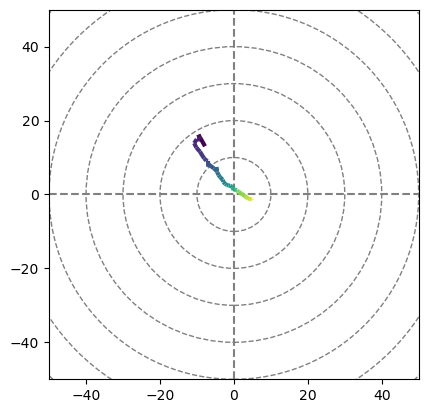

In [10]:
h = Hodograph(component_range=50)
h.add_grid(increment=10)
h.plot_colormapped(u_avg, v_avg, c=zlevels, linewidth=3)
plt.show()